In [65]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
from datetime import datetime
from packaging import version
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import numpy as np

from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import csv
import scipy.stats as stats
from tensorboard.plugins.hparams import api as hp
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (20,10)

import seaborn as sns
from Data import Data
from datetime import datetime
import feature_finder_keiko as ff
plt.rcParams["figure.figsize"] = (20,10)

In [50]:
step = 1
train_start = np.arange(1951,1952,step)
validation_end = np.arange(2000,2001,step)
test_start = np.arange(2001,2002,step)
test_end = np.arange(2005,2006,step)

n_components_sst = 69

In [51]:
tau = 11
f = 12
level = 99

In [52]:
cc = "Aw"
index = np.load("{}_index.npy".format(cc))
index.sort()

In [66]:
ijz = -1
xyz = 20
temporal_limits = {"time_min":datetime(train_start[ijz], 1, 1, 0, 0),"time_max":datetime(validation_end[ijz], 12, 1, 0, 0)}
spi = ff.spi_timeseries("{}_data.npy".format(cc),train_start[ijz],validation_end[ijz],index[xyz])

In [67]:
data_sst = np.load("data_sst.npy")
V = np.load("V.npy")
ts = np.load("ts.npy")
avg = np.load("avg.npy")
std = np.load("std.npy")
data_sst_test = np.load("data_sst_test.npy")
df_sst = pd.read_csv("df_sst.csv")

In [68]:
link  = np.load("../../whole_data_results/{}/best_link_spi/pcmci_{}_{}_{}_{}_{}_{}.npy".format(cc,f,train_start[ijz],validation_end[ijz],tau,n_components_sst,index[xyz]))

In [69]:
temporal_limits_test = {"time_min":datetime(test_start[ijz], 1, 1, 0, 0),"time_max":datetime(test_end[ijz], 12, 1, 0, 0)}
#data_sst_test = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits_test, avg, std, 12, -9.96921e+36)
spi_test = ff.spi_timeseries("{}_data.npy".format(cc),test_start[ijz],test_end[ijz],index[xyz])
del df_sst["Unnamed: 0"]

In [70]:
start_lag = tau
end_lag = tau+11

df = pd.DataFrame({"drought": spi})
lags = np.arange(start_lag,end_lag + 1)
df = df.assign(**{
'{} (t-{})'.format(col, t): df[col].shift(t)
for t in lags
for col in df
})
for k in range(len(link)):
    df[str(k)] = ff.time_series_maker_V(data_sst, V[:,link[k,0]-1])
    df[str(k)] = df[str(k)].shift(abs(link[k,1]))
df = df.dropna()

x_train = df.iloc[:,1:]
y_train = df.iloc[:,0]

In [71]:
start_lag = tau
end_lag = tau + 11

df_test = pd.DataFrame({"drought":spi_test})
lags = np.arange(start_lag,end_lag + 1)
df_test = df_test.assign(**{
'{} (t-{})'.format(col, t): df_test[col].shift(t)
for t in lags
for col in df_test
})
for k in range(len(link)):
    df_sst["pc"] = V[:,link[k,0]-1]
    df_test[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst_test)
    #df_test[str(k)] = ff.time_series_maker_V(data_sst_test, V[:,link[k,0]-1])
    df_test[str(k)] = df_test[str(k)].shift(abs(link[k,1]))
df_test = df_test.dropna()

x_test = df_test.iloc[:,1:]
y_test = df_test.iloc[:,0]

In [ ]:
layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
layers.Dropout(0.1),
layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
layers.Dropout(0.1),

In [88]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

#model = tf.keras.Sequential([
#tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
#layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
#layers.Dropout(0.1),
#layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
#layers.Dropout(0.1),
#layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
#layers.Dense(1)
#])

model = tf.keras.Sequential([
tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
layers.Dropout(0.1),
layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
layers.Dense(1)
])



#model = keras.models.Sequential([
#    keras.layers.Dense(16, input_dim=1),
#    keras.layers.Dense(1),
#])

model.compile(
    loss='mean_squared_error', # keras.losses.mean_squared_error
    optimizer=keras.optimizers.RMSprop(lr=1e-06),
    metrics=['RootMeanSquaredError']
)

print("Training ... With default parameters, this takes less than 10 seconds.")
training_history = model.fit(
    x_train, # input
    y_train, # output
    verbose=True, # Suppress chatty output; use Tensorboard instead
    epochs=1700,
    validation_data=(x_test, y_test),
    callbacks=[tensorboard_callback],
)

print("Average test loss: ", np.average(training_history.history['loss']))


Training ... With default parameters, this takes less than 10 seconds.
Train on 578 samples, validate on 38 samples
Epoch 1/1700
578/578 [==============================] - 0s 783us/sample - loss: 16.5105 - RootMeanSquaredError: 4.0258 - val_loss: 0.8706 - val_RootMeanSquaredError: 0.7530
Epoch 2/1700
578/578 [==============================] - 0s 60us/sample - loss: 16.3078 - RootMeanSquaredError: 4.0005 - val_loss: 0.8709 - val_RootMeanSquaredError: 0.7532
Epoch 3/1700
578/578 [==============================] - 0s 59us/sample - loss: 16.7399 - RootMeanSquaredError: 4.0542 - val_loss: 0.8710 - val_RootMeanSquaredError: 0.7533
Epoch 4/1700
578/578 [==============================] - 0s 62us/sample - loss: 17.6143 - RootMeanSquaredError: 4.1606 - val_loss: 0.8712 - val_RootMeanSquaredError: 0.7534
Epoch 5/1700
578/578 [==============================] - 0s 56us/sample - loss: 16.3019 - RootMeanSquaredError: 3.9998 - val_loss: 0.8714 - val_RootMeanSquaredError: 0.7536
Epoch 6/1700
578/578 [=

Epoch 48/1700
578/578 [==============================] - 0s 60us/sample - loss: 16.1937 - RootMeanSquaredError: 3.9863 - val_loss: 0.8803 - val_RootMeanSquaredError: 0.7596
Epoch 49/1700
578/578 [==============================] - 0s 55us/sample - loss: 16.5364 - RootMeanSquaredError: 4.0290 - val_loss: 0.8805 - val_RootMeanSquaredError: 0.7597
Epoch 50/1700
578/578 [==============================] - 0s 56us/sample - loss: 15.4495 - RootMeanSquaredError: 3.8918 - val_loss: 0.8807 - val_RootMeanSquaredError: 0.7598
Epoch 51/1700
578/578 [==============================] - 0s 53us/sample - loss: 16.1382 - RootMeanSquaredError: 3.9793 - val_loss: 0.8809 - val_RootMeanSquaredError: 0.7600
Epoch 52/1700
578/578 [==============================] - 0s 58us/sample - loss: 17.5769 - RootMeanSquaredError: 4.1561 - val_loss: 0.8812 - val_RootMeanSquaredError: 0.7601
Epoch 53/1700
578/578 [==============================] - 0s 64us/sample - loss: 16.4179 - RootMeanSquaredError: 4.0143 - val_loss: 0.88

578/578 [==============================] - 0s 63us/sample - loss: 16.6505 - RootMeanSquaredError: 4.0432 - val_loss: 0.8904 - val_RootMeanSquaredError: 0.7663
Epoch 96/1700
578/578 [==============================] - 0s 62us/sample - loss: 15.6592 - RootMeanSquaredError: 3.9187 - val_loss: 0.8905 - val_RootMeanSquaredError: 0.7664
Epoch 97/1700
578/578 [==============================] - 0s 65us/sample - loss: 15.9097 - RootMeanSquaredError: 3.9505 - val_loss: 0.8907 - val_RootMeanSquaredError: 0.7665
Epoch 98/1700
578/578 [==============================] - 0s 67us/sample - loss: 16.3668 - RootMeanSquaredError: 4.0079 - val_loss: 0.8910 - val_RootMeanSquaredError: 0.7667
Epoch 99/1700
578/578 [==============================] - 0s 64us/sample - loss: 16.1200 - RootMeanSquaredError: 3.9770 - val_loss: 0.8911 - val_RootMeanSquaredError: 0.7668
Epoch 100/1700
578/578 [==============================] - 0s 65us/sample - loss: 15.8781 - RootMeanSquaredError: 3.9465 - val_loss: 0.8913 - val_Root

578/578 [==============================] - 0s 53us/sample - loss: 15.9269 - RootMeanSquaredError: 3.9527 - val_loss: 0.9001 - val_RootMeanSquaredError: 0.7727
Epoch 143/1700
578/578 [==============================] - 0s 53us/sample - loss: 15.8430 - RootMeanSquaredError: 3.9421 - val_loss: 0.9004 - val_RootMeanSquaredError: 0.7729
Epoch 144/1700
578/578 [==============================] - 0s 52us/sample - loss: 15.2138 - RootMeanSquaredError: 3.8615 - val_loss: 0.9005 - val_RootMeanSquaredError: 0.7730
Epoch 145/1700
578/578 [==============================] - 0s 53us/sample - loss: 15.8395 - RootMeanSquaredError: 3.9416 - val_loss: 0.9007 - val_RootMeanSquaredError: 0.7732
Epoch 146/1700
578/578 [==============================] - 0s 52us/sample - loss: 15.8411 - RootMeanSquaredError: 3.9418 - val_loss: 0.9009 - val_RootMeanSquaredError: 0.7733
Epoch 147/1700
578/578 [==============================] - 0s 53us/sample - loss: 15.1886 - RootMeanSquaredError: 3.8582 - val_loss: 0.9011 - val_

578/578 [==============================] - 0s 62us/sample - loss: 15.9291 - RootMeanSquaredError: 3.9530 - val_loss: 0.9102 - val_RootMeanSquaredError: 0.7793
Epoch 190/1700
578/578 [==============================] - 0s 54us/sample - loss: 15.3786 - RootMeanSquaredError: 3.8828 - val_loss: 0.9104 - val_RootMeanSquaredError: 0.7795
Epoch 191/1700
578/578 [==============================] - 0s 52us/sample - loss: 15.5752 - RootMeanSquaredError: 3.9080 - val_loss: 0.9106 - val_RootMeanSquaredError: 0.7796
Epoch 192/1700
578/578 [==============================] - 0s 65us/sample - loss: 14.9309 - RootMeanSquaredError: 3.8247 - val_loss: 0.9108 - val_RootMeanSquaredError: 0.7798
Epoch 193/1700
578/578 [==============================] - 0s 61us/sample - loss: 14.3207 - RootMeanSquaredError: 3.7441 - val_loss: 0.9110 - val_RootMeanSquaredError: 0.7799
Epoch 194/1700
578/578 [==============================] - 0s 52us/sample - loss: 14.7713 - RootMeanSquaredError: 3.8038 - val_loss: 0.9113 - val_

578/578 [==============================] - 0s 52us/sample - loss: 13.8151 - RootMeanSquaredError: 3.6759 - val_loss: 0.9204 - val_RootMeanSquaredError: 0.7860
Epoch 237/1700
578/578 [==============================] - 0s 55us/sample - loss: 14.3867 - RootMeanSquaredError: 3.7529 - val_loss: 0.9206 - val_RootMeanSquaredError: 0.7861
Epoch 238/1700
578/578 [==============================] - 0s 59us/sample - loss: 15.5639 - RootMeanSquaredError: 3.9066 - val_loss: 0.9208 - val_RootMeanSquaredError: 0.7863
Epoch 239/1700
578/578 [==============================] - 0s 57us/sample - loss: 15.0912 - RootMeanSquaredError: 3.8456 - val_loss: 0.9210 - val_RootMeanSquaredError: 0.7864
Epoch 240/1700
578/578 [==============================] - 0s 56us/sample - loss: 14.6481 - RootMeanSquaredError: 3.7876 - val_loss: 0.9212 - val_RootMeanSquaredError: 0.7865
Epoch 241/1700
578/578 [==============================] - 0s 57us/sample - loss: 14.3059 - RootMeanSquaredError: 3.7421 - val_loss: 0.9214 - val_

578/578 [==============================] - 0s 60us/sample - loss: 14.8176 - RootMeanSquaredError: 3.8099 - val_loss: 0.9303 - val_RootMeanSquaredError: 0.7924
Epoch 284/1700
578/578 [==============================] - 0s 62us/sample - loss: 14.7071 - RootMeanSquaredError: 3.7954 - val_loss: 0.9305 - val_RootMeanSquaredError: 0.7925
Epoch 285/1700
578/578 [==============================] - 0s 52us/sample - loss: 14.2939 - RootMeanSquaredError: 3.7405 - val_loss: 0.9307 - val_RootMeanSquaredError: 0.7927
Epoch 286/1700
578/578 [==============================] - 0s 54us/sample - loss: 14.2723 - RootMeanSquaredError: 3.7376 - val_loss: 0.9309 - val_RootMeanSquaredError: 0.7928
Epoch 287/1700
578/578 [==============================] - 0s 55us/sample - loss: 14.1787 - RootMeanSquaredError: 3.7251 - val_loss: 0.9311 - val_RootMeanSquaredError: 0.7929
Epoch 288/1700
578/578 [==============================] - 0s 53us/sample - loss: 13.7937 - RootMeanSquaredError: 3.6731 - val_loss: 0.9313 - val_

578/578 [==============================] - 0s 53us/sample - loss: 14.2289 - RootMeanSquaredError: 3.7318 - val_loss: 0.9400 - val_RootMeanSquaredError: 0.7986
Epoch 331/1700
578/578 [==============================] - 0s 55us/sample - loss: 14.5045 - RootMeanSquaredError: 3.7686 - val_loss: 0.9402 - val_RootMeanSquaredError: 0.7987
Epoch 332/1700
578/578 [==============================] - 0s 54us/sample - loss: 14.0895 - RootMeanSquaredError: 3.7131 - val_loss: 0.9404 - val_RootMeanSquaredError: 0.7989
Epoch 333/1700
578/578 [==============================] - 0s 52us/sample - loss: 13.1541 - RootMeanSquaredError: 3.5849 - val_loss: 0.9407 - val_RootMeanSquaredError: 0.7990
Epoch 334/1700
578/578 [==============================] - 0s 54us/sample - loss: 13.4766 - RootMeanSquaredError: 3.6297 - val_loss: 0.9409 - val_RootMeanSquaredError: 0.7991
Epoch 335/1700
578/578 [==============================] - 0s 53us/sample - loss: 13.6709 - RootMeanSquaredError: 3.6563 - val_loss: 0.9411 - val_

578/578 [==============================] - 0s 54us/sample - loss: 13.7546 - RootMeanSquaredError: 3.6678 - val_loss: 0.9497 - val_RootMeanSquaredError: 0.8048
Epoch 378/1700
578/578 [==============================] - 0s 52us/sample - loss: 12.7657 - RootMeanSquaredError: 3.5304 - val_loss: 0.9499 - val_RootMeanSquaredError: 0.8049
Epoch 379/1700
578/578 [==============================] - 0s 52us/sample - loss: 13.5041 - RootMeanSquaredError: 3.6335 - val_loss: 0.9501 - val_RootMeanSquaredError: 0.8050
Epoch 380/1700
578/578 [==============================] - 0s 53us/sample - loss: 14.1181 - RootMeanSquaredError: 3.7170 - val_loss: 0.9503 - val_RootMeanSquaredError: 0.8051
Epoch 381/1700
578/578 [==============================] - 0s 56us/sample - loss: 14.2329 - RootMeanSquaredError: 3.7324 - val_loss: 0.9505 - val_RootMeanSquaredError: 0.8053
Epoch 382/1700
578/578 [==============================] - 0s 56us/sample - loss: 14.0908 - RootMeanSquaredError: 3.7133 - val_loss: 0.9507 - val_

578/578 [==============================] - 0s 62us/sample - loss: 12.7277 - RootMeanSquaredError: 3.5250 - val_loss: 0.9594 - val_RootMeanSquaredError: 0.8109
Epoch 425/1700
578/578 [==============================] - 0s 56us/sample - loss: 12.3425 - RootMeanSquaredError: 3.4700 - val_loss: 0.9596 - val_RootMeanSquaredError: 0.8110
Epoch 426/1700
578/578 [==============================] - 0s 55us/sample - loss: 12.8314 - RootMeanSquaredError: 3.5397 - val_loss: 0.9598 - val_RootMeanSquaredError: 0.8111
Epoch 427/1700
578/578 [==============================] - 0s 53us/sample - loss: 13.6006 - RootMeanSquaredError: 3.6467 - val_loss: 0.9601 - val_RootMeanSquaredError: 0.8113
Epoch 428/1700
578/578 [==============================] - 0s 53us/sample - loss: 14.3070 - RootMeanSquaredError: 3.7423 - val_loss: 0.9603 - val_RootMeanSquaredError: 0.8114
Epoch 429/1700
578/578 [==============================] - 0s 55us/sample - loss: 13.3499 - RootMeanSquaredError: 3.6122 - val_loss: 0.9605 - val_

578/578 [==============================] - 0s 52us/sample - loss: 12.3654 - RootMeanSquaredError: 3.4733 - val_loss: 0.9692 - val_RootMeanSquaredError: 0.8170
Epoch 472/1700
578/578 [==============================] - 0s 54us/sample - loss: 11.7010 - RootMeanSquaredError: 3.3763 - val_loss: 0.9694 - val_RootMeanSquaredError: 0.8171
Epoch 473/1700
578/578 [==============================] - 0s 54us/sample - loss: 13.3637 - RootMeanSquaredError: 3.6141 - val_loss: 0.9696 - val_RootMeanSquaredError: 0.8173
Epoch 474/1700
578/578 [==============================] - 0s 55us/sample - loss: 12.8328 - RootMeanSquaredError: 3.5399 - val_loss: 0.9698 - val_RootMeanSquaredError: 0.8174
Epoch 475/1700
578/578 [==============================] - 0s 56us/sample - loss: 13.0102 - RootMeanSquaredError: 3.5649 - val_loss: 0.9701 - val_RootMeanSquaredError: 0.8175
Epoch 476/1700
578/578 [==============================] - 0s 57us/sample - loss: 13.0816 - RootMeanSquaredError: 3.5749 - val_loss: 0.9703 - val_

578/578 [==============================] - 0s 56us/sample - loss: 13.3498 - RootMeanSquaredError: 3.6122 - val_loss: 0.9791 - val_RootMeanSquaredError: 0.8231
Epoch 519/1700
578/578 [==============================] - 0s 57us/sample - loss: 12.4360 - RootMeanSquaredError: 3.4834 - val_loss: 0.9793 - val_RootMeanSquaredError: 0.8233
Epoch 520/1700
578/578 [==============================] - 0s 62us/sample - loss: 12.9800 - RootMeanSquaredError: 3.5607 - val_loss: 0.9795 - val_RootMeanSquaredError: 0.8234
Epoch 521/1700
578/578 [==============================] - 0s 53us/sample - loss: 12.6254 - RootMeanSquaredError: 3.5105 - val_loss: 0.9797 - val_RootMeanSquaredError: 0.8235
Epoch 522/1700
578/578 [==============================] - 0s 58us/sample - loss: 12.9111 - RootMeanSquaredError: 3.5510 - val_loss: 0.9800 - val_RootMeanSquaredError: 0.8237
Epoch 523/1700
578/578 [==============================] - 0s 53us/sample - loss: 12.7141 - RootMeanSquaredError: 3.5231 - val_loss: 0.9802 - val_

578/578 [==============================] - 0s 53us/sample - loss: 12.1588 - RootMeanSquaredError: 3.4435 - val_loss: 0.9890 - val_RootMeanSquaredError: 0.8292
Epoch 566/1700
578/578 [==============================] - 0s 56us/sample - loss: 12.4558 - RootMeanSquaredError: 3.4863 - val_loss: 0.9892 - val_RootMeanSquaredError: 0.8293
Epoch 567/1700
578/578 [==============================] - 0s 58us/sample - loss: 12.2882 - RootMeanSquaredError: 3.4622 - val_loss: 0.9894 - val_RootMeanSquaredError: 0.8295
Epoch 568/1700
578/578 [==============================] - 0s 61us/sample - loss: 13.0490 - RootMeanSquaredError: 3.5704 - val_loss: 0.9896 - val_RootMeanSquaredError: 0.8296
Epoch 569/1700
578/578 [==============================] - 0s 53us/sample - loss: 12.2854 - RootMeanSquaredError: 3.4618 - val_loss: 0.9898 - val_RootMeanSquaredError: 0.8297
Epoch 570/1700
578/578 [==============================] - 0s 57us/sample - loss: 12.4989 - RootMeanSquaredError: 3.4925 - val_loss: 0.9900 - val_

578/578 [==============================] - 0s 58us/sample - loss: 12.1342 - RootMeanSquaredError: 3.4399 - val_loss: 0.9987 - val_RootMeanSquaredError: 0.8352
Epoch 613/1700
578/578 [==============================] - 0s 63us/sample - loss: 12.4224 - RootMeanSquaredError: 3.4816 - val_loss: 0.9989 - val_RootMeanSquaredError: 0.8353
Epoch 614/1700
578/578 [==============================] - 0s 54us/sample - loss: 12.4519 - RootMeanSquaredError: 3.4858 - val_loss: 0.9991 - val_RootMeanSquaredError: 0.8354
Epoch 615/1700
578/578 [==============================] - 0s 55us/sample - loss: 12.4944 - RootMeanSquaredError: 3.4919 - val_loss: 0.9993 - val_RootMeanSquaredError: 0.8355
Epoch 616/1700
578/578 [==============================] - 0s 54us/sample - loss: 12.6203 - RootMeanSquaredError: 3.5099 - val_loss: 0.9996 - val_RootMeanSquaredError: 0.8357
Epoch 617/1700
578/578 [==============================] - 0s 65us/sample - loss: 12.8621 - RootMeanSquaredError: 3.5441 - val_loss: 0.9998 - val_

578/578 [==============================] - 0s 56us/sample - loss: 12.3670 - RootMeanSquaredError: 3.4736 - val_loss: 1.0087 - val_RootMeanSquaredError: 0.8412
Epoch 660/1700
578/578 [==============================] - 0s 57us/sample - loss: 11.9010 - RootMeanSquaredError: 3.4059 - val_loss: 1.0089 - val_RootMeanSquaredError: 0.8414
Epoch 661/1700
578/578 [==============================] - 0s 54us/sample - loss: 11.9050 - RootMeanSquaredError: 3.4065 - val_loss: 1.0091 - val_RootMeanSquaredError: 0.8415
Epoch 662/1700
578/578 [==============================] - 0s 56us/sample - loss: 11.0641 - RootMeanSquaredError: 3.2807 - val_loss: 1.0093 - val_RootMeanSquaredError: 0.8416
Epoch 663/1700
578/578 [==============================] - 0s 62us/sample - loss: 11.4024 - RootMeanSquaredError: 3.3319 - val_loss: 1.0095 - val_RootMeanSquaredError: 0.8417
Epoch 664/1700
578/578 [==============================] - 0s 53us/sample - loss: 11.7691 - RootMeanSquaredError: 3.3865 - val_loss: 1.0098 - val_

578/578 [==============================] - 0s 54us/sample - loss: 11.4087 - RootMeanSquaredError: 3.3328 - val_loss: 1.0185 - val_RootMeanSquaredError: 0.8471
Epoch 707/1700
578/578 [==============================] - 0s 55us/sample - loss: 10.3707 - RootMeanSquaredError: 3.1733 - val_loss: 1.0187 - val_RootMeanSquaredError: 0.8472
Epoch 708/1700
578/578 [==============================] - 0s 58us/sample - loss: 11.9257 - RootMeanSquaredError: 3.4095 - val_loss: 1.0189 - val_RootMeanSquaredError: 0.8474
Epoch 709/1700
578/578 [==============================] - 0s 53us/sample - loss: 11.2001 - RootMeanSquaredError: 3.3014 - val_loss: 1.0191 - val_RootMeanSquaredError: 0.8475
Epoch 710/1700
578/578 [==============================] - 0s 55us/sample - loss: 11.3702 - RootMeanSquaredError: 3.3271 - val_loss: 1.0193 - val_RootMeanSquaredError: 0.8476
Epoch 711/1700
578/578 [==============================] - 0s 56us/sample - loss: 12.5237 - RootMeanSquaredError: 3.4961 - val_loss: 1.0196 - val_

578/578 [==============================] - 0s 53us/sample - loss: 10.8687 - RootMeanSquaredError: 3.2508 - val_loss: 1.0285 - val_RootMeanSquaredError: 0.8531
Epoch 754/1700
578/578 [==============================] - 0s 53us/sample - loss: 11.0480 - RootMeanSquaredError: 3.2783 - val_loss: 1.0287 - val_RootMeanSquaredError: 0.8532
Epoch 755/1700
578/578 [==============================] - 0s 52us/sample - loss: 11.4377 - RootMeanSquaredError: 3.3372 - val_loss: 1.0289 - val_RootMeanSquaredError: 0.8533
Epoch 756/1700
578/578 [==============================] - 0s 56us/sample - loss: 10.6023 - RootMeanSquaredError: 3.2096 - val_loss: 1.0291 - val_RootMeanSquaredError: 0.8534
Epoch 757/1700
578/578 [==============================] - 0s 54us/sample - loss: 11.2460 - RootMeanSquaredError: 3.3084 - val_loss: 1.0293 - val_RootMeanSquaredError: 0.8536
Epoch 758/1700
578/578 [==============================] - 0s 53us/sample - loss: 10.5176 - RootMeanSquaredError: 3.1964 - val_loss: 1.0295 - val_

Epoch 800/1700
578/578 [==============================] - 0s 56us/sample - loss: 11.2313 - RootMeanSquaredError: 3.3062 - val_loss: 1.0381 - val_RootMeanSquaredError: 0.8588
Epoch 801/1700
578/578 [==============================] - 0s 58us/sample - loss: 10.0933 - RootMeanSquaredError: 3.1293 - val_loss: 1.0383 - val_RootMeanSquaredError: 0.8589
Epoch 802/1700
578/578 [==============================] - 0s 55us/sample - loss: 11.6855 - RootMeanSquaredError: 3.3742 - val_loss: 1.0385 - val_RootMeanSquaredError: 0.8590
Epoch 803/1700
578/578 [==============================] - 0s 55us/sample - loss: 11.5796 - RootMeanSquaredError: 3.3584 - val_loss: 1.0386 - val_RootMeanSquaredError: 0.8591
Epoch 804/1700
578/578 [==============================] - 0s 55us/sample - loss: 10.7492 - RootMeanSquaredError: 3.2324 - val_loss: 1.0388 - val_RootMeanSquaredError: 0.8592
Epoch 805/1700
578/578 [==============================] - 0s 53us/sample - loss: 10.1836 - RootMeanSquaredError: 3.1437 - val_loss

578/578 [==============================] - 0s 54us/sample - loss: 10.9719 - RootMeanSquaredError: 3.2667 - val_loss: 1.0471 - val_RootMeanSquaredError: 0.8641
Epoch 848/1700
578/578 [==============================] - 0s 52us/sample - loss: 10.1310 - RootMeanSquaredError: 3.1354 - val_loss: 1.0474 - val_RootMeanSquaredError: 0.8643
Epoch 849/1700
578/578 [==============================] - 0s 53us/sample - loss: 10.0136 - RootMeanSquaredError: 3.1166 - val_loss: 1.0475 - val_RootMeanSquaredError: 0.8643
Epoch 850/1700
578/578 [==============================] - 0s 53us/sample - loss: 10.4331 - RootMeanSquaredError: 3.1832 - val_loss: 1.0477 - val_RootMeanSquaredError: 0.8645
Epoch 851/1700
578/578 [==============================] - 0s 53us/sample - loss: 10.9581 - RootMeanSquaredError: 3.2646 - val_loss: 1.0479 - val_RootMeanSquaredError: 0.8646
Epoch 852/1700
578/578 [==============================] - 0s 55us/sample - loss: 10.5629 - RootMeanSquaredError: 3.2035 - val_loss: 1.0481 - val_

578/578 [==============================] - 0s 57us/sample - loss: 11.0173 - RootMeanSquaredError: 3.2737 - val_loss: 1.0564 - val_RootMeanSquaredError: 0.8695
Epoch 895/1700
578/578 [==============================] - 0s 54us/sample - loss: 9.8790 - RootMeanSquaredError: 3.0949 - val_loss: 1.0565 - val_RootMeanSquaredError: 0.8696
Epoch 896/1700
578/578 [==============================] - 0s 59us/sample - loss: 10.4265 - RootMeanSquaredError: 3.1822 - val_loss: 1.0568 - val_RootMeanSquaredError: 0.8698
Epoch 897/1700
578/578 [==============================] - 0s 53us/sample - loss: 10.7238 - RootMeanSquaredError: 3.2286 - val_loss: 1.0569 - val_RootMeanSquaredError: 0.8698
Epoch 898/1700
578/578 [==============================] - 0s 58us/sample - loss: 10.3263 - RootMeanSquaredError: 3.1664 - val_loss: 1.0571 - val_RootMeanSquaredError: 0.8700
Epoch 899/1700
578/578 [==============================] - 0s 56us/sample - loss: 10.5139 - RootMeanSquaredError: 3.1959 - val_loss: 1.0573 - val_R

578/578 [==============================] - 0s 53us/sample - loss: 9.4632 - RootMeanSquaredError: 3.0271 - val_loss: 1.0654 - val_RootMeanSquaredError: 0.8748
Epoch 941/1700
578/578 [==============================] - 0s 53us/sample - loss: 10.4431 - RootMeanSquaredError: 3.1848 - val_loss: 1.0656 - val_RootMeanSquaredError: 0.8749
Epoch 942/1700
578/578 [==============================] - 0s 54us/sample - loss: 9.1857 - RootMeanSquaredError: 2.9809 - val_loss: 1.0658 - val_RootMeanSquaredError: 0.8750
Epoch 943/1700
578/578 [==============================] - 0s 54us/sample - loss: 10.7451 - RootMeanSquaredError: 3.2319 - val_loss: 1.0660 - val_RootMeanSquaredError: 0.8752
Epoch 944/1700
578/578 [==============================] - 0s 52us/sample - loss: 10.2253 - RootMeanSquaredError: 3.1504 - val_loss: 1.0662 - val_RootMeanSquaredError: 0.8753
Epoch 945/1700
578/578 [==============================] - 0s 52us/sample - loss: 10.0826 - RootMeanSquaredError: 3.1277 - val_loss: 1.0664 - val_Ro

578/578 [==============================] - 0s 61us/sample - loss: 8.9162 - RootMeanSquaredError: 2.9353 - val_loss: 1.0747 - val_RootMeanSquaredError: 0.8802
Epoch 988/1700
578/578 [==============================] - 0s 58us/sample - loss: 9.8344 - RootMeanSquaredError: 3.0878 - val_loss: 1.0749 - val_RootMeanSquaredError: 0.8803
Epoch 989/1700
578/578 [==============================] - 0s 61us/sample - loss: 9.9647 - RootMeanSquaredError: 3.1088 - val_loss: 1.0751 - val_RootMeanSquaredError: 0.8804
Epoch 990/1700
578/578 [==============================] - 0s 57us/sample - loss: 10.1650 - RootMeanSquaredError: 3.1409 - val_loss: 1.0753 - val_RootMeanSquaredError: 0.8805
Epoch 991/1700
578/578 [==============================] - 0s 60us/sample - loss: 9.8024 - RootMeanSquaredError: 3.0826 - val_loss: 1.0755 - val_RootMeanSquaredError: 0.8807
Epoch 992/1700
578/578 [==============================] - 0s 71us/sample - loss: 9.4342 - RootMeanSquaredError: 3.0223 - val_loss: 1.0757 - val_RootM

578/578 [==============================] - 0s 56us/sample - loss: 9.4452 - RootMeanSquaredError: 3.0241 - val_loss: 1.0840 - val_RootMeanSquaredError: 0.8855
Epoch 1035/1700
578/578 [==============================] - 0s 54us/sample - loss: 9.1605 - RootMeanSquaredError: 2.9767 - val_loss: 1.0842 - val_RootMeanSquaredError: 0.8857
Epoch 1036/1700
578/578 [==============================] - 0s 53us/sample - loss: 9.2192 - RootMeanSquaredError: 2.9865 - val_loss: 1.0844 - val_RootMeanSquaredError: 0.8858
Epoch 1037/1700
578/578 [==============================] - 0s 58us/sample - loss: 10.7417 - RootMeanSquaredError: 3.2314 - val_loss: 1.0846 - val_RootMeanSquaredError: 0.8859
Epoch 1038/1700
578/578 [==============================] - 0s 55us/sample - loss: 9.2254 - RootMeanSquaredError: 2.9876 - val_loss: 1.0848 - val_RootMeanSquaredError: 0.8860
Epoch 1039/1700
578/578 [==============================] - 0s 55us/sample - loss: 9.7357 - RootMeanSquaredError: 3.0718 - val_loss: 1.0850 - val_

578/578 [==============================] - 0s 58us/sample - loss: 9.5981 - RootMeanSquaredError: 3.0493 - val_loss: 1.0933 - val_RootMeanSquaredError: 0.8908
Epoch 1082/1700
578/578 [==============================] - 0s 54us/sample - loss: 10.1002 - RootMeanSquaredError: 3.1306 - val_loss: 1.0935 - val_RootMeanSquaredError: 0.8909
Epoch 1083/1700
578/578 [==============================] - 0s 53us/sample - loss: 9.4362 - RootMeanSquaredError: 3.0227 - val_loss: 1.0937 - val_RootMeanSquaredError: 0.8910
Epoch 1084/1700
578/578 [==============================] - 0s 58us/sample - loss: 8.9901 - RootMeanSquaredError: 2.9480 - val_loss: 1.0939 - val_RootMeanSquaredError: 0.8912
Epoch 1085/1700
578/578 [==============================] - 0s 52us/sample - loss: 9.4107 - RootMeanSquaredError: 3.0184 - val_loss: 1.0941 - val_RootMeanSquaredError: 0.8913
Epoch 1086/1700
578/578 [==============================] - 0s 52us/sample - loss: 9.4608 - RootMeanSquaredError: 3.0267 - val_loss: 1.0943 - val_

578/578 [==============================] - 0s 56us/sample - loss: 9.6677 - RootMeanSquaredError: 3.0607 - val_loss: 1.1025 - val_RootMeanSquaredError: 0.8961
Epoch 1129/1700
578/578 [==============================] - 0s 56us/sample - loss: 8.9695 - RootMeanSquaredError: 2.9445 - val_loss: 1.1027 - val_RootMeanSquaredError: 0.8962
Epoch 1130/1700
578/578 [==============================] - 0s 57us/sample - loss: 8.8391 - RootMeanSquaredError: 2.9223 - val_loss: 1.1029 - val_RootMeanSquaredError: 0.8963
Epoch 1131/1700
578/578 [==============================] - 0s 56us/sample - loss: 10.0852 - RootMeanSquaredError: 3.1282 - val_loss: 1.1031 - val_RootMeanSquaredError: 0.8964
Epoch 1132/1700
578/578 [==============================] - 0s 56us/sample - loss: 9.5989 - RootMeanSquaredError: 3.0495 - val_loss: 1.1033 - val_RootMeanSquaredError: 0.8965
Epoch 1133/1700
578/578 [==============================] - 0s 56us/sample - loss: 9.3567 - RootMeanSquaredError: 3.0095 - val_loss: 1.1035 - val_

578/578 [==============================] - 0s 52us/sample - loss: 8.9425 - RootMeanSquaredError: 2.9399 - val_loss: 1.1117 - val_RootMeanSquaredError: 0.9012
Epoch 1176/1700
578/578 [==============================] - 0s 55us/sample - loss: 8.7286 - RootMeanSquaredError: 2.9033 - val_loss: 1.1118 - val_RootMeanSquaredError: 0.9013
Epoch 1177/1700
578/578 [==============================] - 0s 55us/sample - loss: 9.2282 - RootMeanSquaredError: 2.9881 - val_loss: 1.1121 - val_RootMeanSquaredError: 0.9015
Epoch 1178/1700
578/578 [==============================] - 0s 55us/sample - loss: 9.1475 - RootMeanSquaredError: 2.9746 - val_loss: 1.1123 - val_RootMeanSquaredError: 0.9016
Epoch 1179/1700
578/578 [==============================] - 0s 51us/sample - loss: 9.2842 - RootMeanSquaredError: 2.9975 - val_loss: 1.1125 - val_RootMeanSquaredError: 0.9017
Epoch 1180/1700
578/578 [==============================] - 0s 55us/sample - loss: 8.6715 - RootMeanSquaredError: 2.8935 - val_loss: 1.1127 - val_R

Epoch 1222/1700
578/578 [==============================] - 0s 54us/sample - loss: 8.9726 - RootMeanSquaredError: 2.9450 - val_loss: 1.1206 - val_RootMeanSquaredError: 0.9063
Epoch 1223/1700
578/578 [==============================] - 0s 52us/sample - loss: 9.2886 - RootMeanSquaredError: 2.9982 - val_loss: 1.1208 - val_RootMeanSquaredError: 0.9064
Epoch 1224/1700
578/578 [==============================] - 0s 58us/sample - loss: 8.3405 - RootMeanSquaredError: 2.8357 - val_loss: 1.1210 - val_RootMeanSquaredError: 0.9065
Epoch 1225/1700
578/578 [==============================] - 0s 55us/sample - loss: 8.2529 - RootMeanSquaredError: 2.8202 - val_loss: 1.1212 - val_RootMeanSquaredError: 0.9066
Epoch 1226/1700
578/578 [==============================] - 0s 51us/sample - loss: 8.5942 - RootMeanSquaredError: 2.8801 - val_loss: 1.1214 - val_RootMeanSquaredError: 0.9067
Epoch 1227/1700
578/578 [==============================] - 0s 52us/sample - loss: 8.6247 - RootMeanSquaredError: 2.8854 - val_loss

578/578 [==============================] - 0s 53us/sample - loss: 8.4861 - RootMeanSquaredError: 2.8613 - val_loss: 1.1293 - val_RootMeanSquaredError: 0.9111
Epoch 1270/1700
578/578 [==============================] - 0s 53us/sample - loss: 9.1529 - RootMeanSquaredError: 2.9755 - val_loss: 1.1295 - val_RootMeanSquaredError: 0.9112
Epoch 1271/1700
578/578 [==============================] - 0s 53us/sample - loss: 8.4631 - RootMeanSquaredError: 2.8573 - val_loss: 1.1297 - val_RootMeanSquaredError: 0.9113
Epoch 1272/1700
578/578 [==============================] - 0s 56us/sample - loss: 8.4093 - RootMeanSquaredError: 2.8478 - val_loss: 1.1299 - val_RootMeanSquaredError: 0.9114
Epoch 1273/1700
578/578 [==============================] - 0s 56us/sample - loss: 8.5469 - RootMeanSquaredError: 2.8719 - val_loss: 1.1301 - val_RootMeanSquaredError: 0.9115
Epoch 1274/1700
578/578 [==============================] - 0s 55us/sample - loss: 8.5341 - RootMeanSquaredError: 2.8697 - val_loss: 1.1303 - val_R

578/578 [==============================] - 0s 55us/sample - loss: 8.9775 - RootMeanSquaredError: 2.9459 - val_loss: 1.1382 - val_RootMeanSquaredError: 0.9160
Epoch 1317/1700
578/578 [==============================] - 0s 61us/sample - loss: 8.0934 - RootMeanSquaredError: 2.7918 - val_loss: 1.1384 - val_RootMeanSquaredError: 0.9161
Epoch 1318/1700
578/578 [==============================] - 0s 58us/sample - loss: 8.3830 - RootMeanSquaredError: 2.8432 - val_loss: 1.1385 - val_RootMeanSquaredError: 0.9163
Epoch 1319/1700
578/578 [==============================] - 0s 56us/sample - loss: 7.9463 - RootMeanSquaredError: 2.7654 - val_loss: 1.1387 - val_RootMeanSquaredError: 0.9164
Epoch 1320/1700
578/578 [==============================] - 0s 54us/sample - loss: 8.1174 - RootMeanSquaredError: 2.7961 - val_loss: 1.1389 - val_RootMeanSquaredError: 0.9165
Epoch 1321/1700
578/578 [==============================] - 0s 56us/sample - loss: 8.0523 - RootMeanSquaredError: 2.7845 - val_loss: 1.1391 - val_R

578/578 [==============================] - 0s 57us/sample - loss: 8.0869 - RootMeanSquaredError: 2.7907 - val_loss: 1.1468 - val_RootMeanSquaredError: 0.9208
Epoch 1364/1700
578/578 [==============================] - 0s 58us/sample - loss: 8.2661 - RootMeanSquaredError: 2.8226 - val_loss: 1.1470 - val_RootMeanSquaredError: 0.9209
Epoch 1365/1700
578/578 [==============================] - 0s 63us/sample - loss: 8.2176 - RootMeanSquaredError: 2.8140 - val_loss: 1.1472 - val_RootMeanSquaredError: 0.9210
Epoch 1366/1700
578/578 [==============================] - 0s 55us/sample - loss: 8.0118 - RootMeanSquaredError: 2.7772 - val_loss: 1.1474 - val_RootMeanSquaredError: 0.9211
Epoch 1367/1700
578/578 [==============================] - 0s 54us/sample - loss: 8.3124 - RootMeanSquaredError: 2.8308 - val_loss: 1.1476 - val_RootMeanSquaredError: 0.9213
Epoch 1368/1700
578/578 [==============================] - 0s 53us/sample - loss: 8.7442 - RootMeanSquaredError: 2.9061 - val_loss: 1.1478 - val_R

578/578 [==============================] - 0s 52us/sample - loss: 7.6718 - RootMeanSquaredError: 2.7153 - val_loss: 1.1554 - val_RootMeanSquaredError: 0.9256
Epoch 1411/1700
578/578 [==============================] - 0s 52us/sample - loss: 7.9286 - RootMeanSquaredError: 2.7622 - val_loss: 1.1556 - val_RootMeanSquaredError: 0.9257
Epoch 1412/1700
578/578 [==============================] - 0s 56us/sample - loss: 7.7621 - RootMeanSquaredError: 2.7319 - val_loss: 1.1558 - val_RootMeanSquaredError: 0.9258
Epoch 1413/1700
578/578 [==============================] - 0s 55us/sample - loss: 8.5276 - RootMeanSquaredError: 2.8686 - val_loss: 1.1560 - val_RootMeanSquaredError: 0.9259
Epoch 1414/1700
578/578 [==============================] - 0s 61us/sample - loss: 8.0554 - RootMeanSquaredError: 2.7851 - val_loss: 1.1562 - val_RootMeanSquaredError: 0.9260
Epoch 1415/1700
578/578 [==============================] - 0s 54us/sample - loss: 7.6586 - RootMeanSquaredError: 2.7129 - val_loss: 1.1564 - val_R

578/578 [==============================] - 0s 53us/sample - loss: 8.0035 - RootMeanSquaredError: 2.7758 - val_loss: 1.1641 - val_RootMeanSquaredError: 0.9303
Epoch 1458/1700
578/578 [==============================] - 0s 53us/sample - loss: 7.5013 - RootMeanSquaredError: 2.6838 - val_loss: 1.1642 - val_RootMeanSquaredError: 0.9304
Epoch 1459/1700
578/578 [==============================] - 0s 53us/sample - loss: 7.9208 - RootMeanSquaredError: 2.7608 - val_loss: 1.1644 - val_RootMeanSquaredError: 0.9305
Epoch 1460/1700
578/578 [==============================] - 0s 52us/sample - loss: 7.2006 - RootMeanSquaredError: 2.6272 - val_loss: 1.1646 - val_RootMeanSquaredError: 0.9306
Epoch 1461/1700
578/578 [==============================] - 0s 52us/sample - loss: 7.4540 - RootMeanSquaredError: 2.6749 - val_loss: 1.1648 - val_RootMeanSquaredError: 0.9307
Epoch 1462/1700
578/578 [==============================] - 0s 52us/sample - loss: 7.7386 - RootMeanSquaredError: 2.7276 - val_loss: 1.1650 - val_R

578/578 [==============================] - 0s 56us/sample - loss: 7.6458 - RootMeanSquaredError: 2.7106 - val_loss: 1.1726 - val_RootMeanSquaredError: 0.9349
Epoch 1505/1700
578/578 [==============================] - 0s 57us/sample - loss: 7.7167 - RootMeanSquaredError: 2.7236 - val_loss: 1.1728 - val_RootMeanSquaredError: 0.9350
Epoch 1506/1700
578/578 [==============================] - 0s 57us/sample - loss: 7.9847 - RootMeanSquaredError: 2.7724 - val_loss: 1.1730 - val_RootMeanSquaredError: 0.9351
Epoch 1507/1700
578/578 [==============================] - 0s 71us/sample - loss: 8.2437 - RootMeanSquaredError: 2.8187 - val_loss: 1.1732 - val_RootMeanSquaredError: 0.9352
Epoch 1508/1700
578/578 [==============================] - 0s 66us/sample - loss: 7.5842 - RootMeanSquaredError: 2.6992 - val_loss: 1.1734 - val_RootMeanSquaredError: 0.9354
Epoch 1509/1700
578/578 [==============================] - 0s 66us/sample - loss: 7.5412 - RootMeanSquaredError: 2.6912 - val_loss: 1.1736 - val_R

578/578 [==============================] - 0s 93us/sample - loss: 7.9189 - RootMeanSquaredError: 2.7605 - val_loss: 1.1814 - val_RootMeanSquaredError: 0.9397
Epoch 1552/1700
578/578 [==============================] - 0s 93us/sample - loss: 7.6624 - RootMeanSquaredError: 2.7137 - val_loss: 1.1816 - val_RootMeanSquaredError: 0.9398
Epoch 1553/1700
578/578 [==============================] - 0s 84us/sample - loss: 7.9670 - RootMeanSquaredError: 2.7692 - val_loss: 1.1818 - val_RootMeanSquaredError: 0.9399
Epoch 1554/1700
578/578 [==============================] - 0s 58us/sample - loss: 6.9707 - RootMeanSquaredError: 2.5831 - val_loss: 1.1820 - val_RootMeanSquaredError: 0.9400
Epoch 1555/1700
578/578 [==============================] - 0s 53us/sample - loss: 8.0318 - RootMeanSquaredError: 2.7809 - val_loss: 1.1821 - val_RootMeanSquaredError: 0.9401
Epoch 1556/1700
578/578 [==============================] - 0s 54us/sample - loss: 7.4113 - RootMeanSquaredError: 2.6670 - val_loss: 1.1823 - val_R

578/578 [==============================] - 0s 55us/sample - loss: 7.6347 - RootMeanSquaredError: 2.7086 - val_loss: 1.1901 - val_RootMeanSquaredError: 0.9444
Epoch 1599/1700
578/578 [==============================] - 0s 56us/sample - loss: 6.7768 - RootMeanSquaredError: 2.5453 - val_loss: 1.1903 - val_RootMeanSquaredError: 0.9445
Epoch 1600/1700
578/578 [==============================] - 0s 53us/sample - loss: 7.2060 - RootMeanSquaredError: 2.6283 - val_loss: 1.1905 - val_RootMeanSquaredError: 0.9446
Epoch 1601/1700
578/578 [==============================] - 0s 54us/sample - loss: 6.9690 - RootMeanSquaredError: 2.5828 - val_loss: 1.1906 - val_RootMeanSquaredError: 0.9446
Epoch 1602/1700
578/578 [==============================] - 0s 53us/sample - loss: 7.4588 - RootMeanSquaredError: 2.6759 - val_loss: 1.1908 - val_RootMeanSquaredError: 0.9447
Epoch 1603/1700
578/578 [==============================] - 0s 53us/sample - loss: 7.2216 - RootMeanSquaredError: 2.6312 - val_loss: 1.1910 - val_R

578/578 [==============================] - 0s 53us/sample - loss: 6.7264 - RootMeanSquaredError: 2.5354 - val_loss: 1.1983 - val_RootMeanSquaredError: 0.9488
Epoch 1646/1700
578/578 [==============================] - 0s 53us/sample - loss: 7.5037 - RootMeanSquaredError: 2.6843 - val_loss: 1.1985 - val_RootMeanSquaredError: 0.9489
Epoch 1647/1700
578/578 [==============================] - 0s 53us/sample - loss: 6.9517 - RootMeanSquaredError: 2.5795 - val_loss: 1.1987 - val_RootMeanSquaredError: 0.9490
Epoch 1648/1700
578/578 [==============================] - 0s 51us/sample - loss: 7.0553 - RootMeanSquaredError: 2.5995 - val_loss: 1.1989 - val_RootMeanSquaredError: 0.9491
Epoch 1649/1700
578/578 [==============================] - 0s 53us/sample - loss: 7.2612 - RootMeanSquaredError: 2.6388 - val_loss: 1.1990 - val_RootMeanSquaredError: 0.9492
Epoch 1650/1700
578/578 [==============================] - 0s 53us/sample - loss: 7.4145 - RootMeanSquaredError: 2.6676 - val_loss: 1.1992 - val_R

578/578 [==============================] - 0s 54us/sample - loss: 7.3876 - RootMeanSquaredError: 2.6626 - val_loss: 1.2063 - val_RootMeanSquaredError: 0.9530
Epoch 1693/1700
578/578 [==============================] - 0s 56us/sample - loss: 6.4159 - RootMeanSquaredError: 2.4734 - val_loss: 1.2064 - val_RootMeanSquaredError: 0.9531
Epoch 1694/1700
578/578 [==============================] - 0s 64us/sample - loss: 6.9717 - RootMeanSquaredError: 2.5833 - val_loss: 1.2066 - val_RootMeanSquaredError: 0.9532
Epoch 1695/1700
578/578 [==============================] - 0s 58us/sample - loss: 6.8145 - RootMeanSquaredError: 2.5527 - val_loss: 1.2068 - val_RootMeanSquaredError: 0.9533
Epoch 1696/1700
578/578 [==============================] - 0s 62us/sample - loss: 7.4943 - RootMeanSquaredError: 2.6826 - val_loss: 1.2070 - val_RootMeanSquaredError: 0.9534
Epoch 1697/1700
578/578 [==============================] - 0s 59us/sample - loss: 6.8087 - RootMeanSquaredError: 2.5516 - val_loss: 1.2072 - val_R

In [74]:
%tensorboard --logdir logs/scalars

Reusing TensorBoard on port 6006 (pid 28201), started 0:04:07 ago. (Use '!kill 28201' to kill it.)

In [105]:
x = np.arange('2011-12', '2015-01', dtype='datetime64[M]')

In [106]:
len(x)

37

In [89]:
y_pred = model.predict(x_test)

In [62]:
y_pred[y_pred>3] = 2.5
y_pred[y_pred<-3] = -2.5

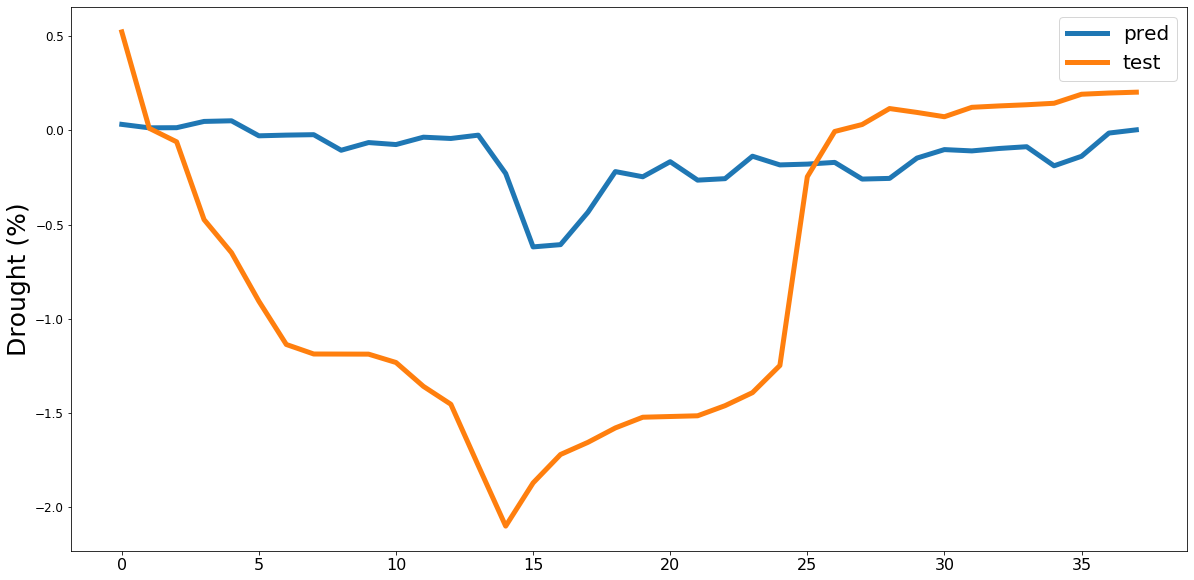

In [90]:
x = range(len(y_pred))
plt.plot(x,y_pred,label = 'pred', linewidth = 5)
plt.plot(x, y_test, label = 'test', linewidth = 5)
plt.ylabel("Drought (%)", fontsize = 25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=20)
#plt.savefig("ET_pred_test_ijz_2_extreme_1.png")

In [120]:
y_pred.s

(37, 1)

In [124]:
sns.set_style(style="darkgrid")

In [121]:
data  = pd.DataFrame({"date":x, "test":np.ravel(y_test), "pred":np.ravel(y_pred)})

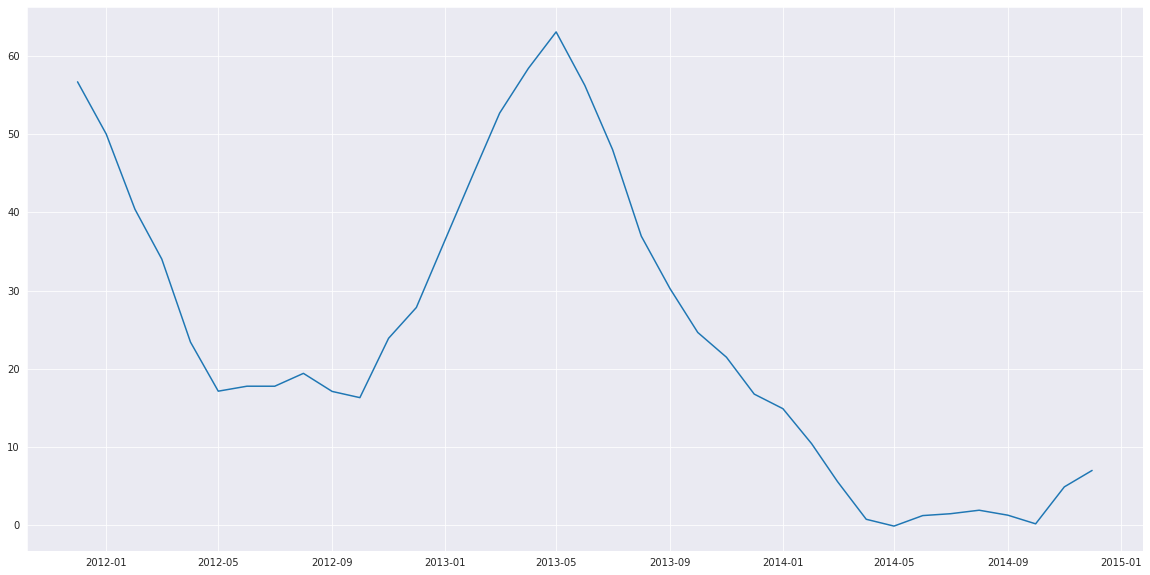

In [125]:
sns.lineplot(x,np.ravel(y_pred))

In [ ]:
x,o

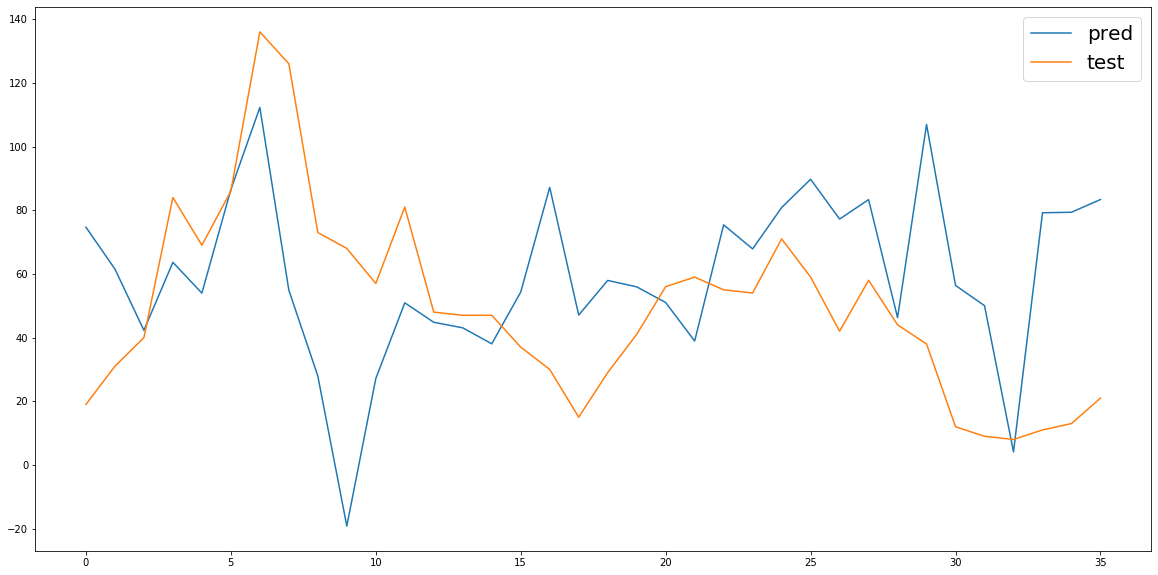

In [17]:
limit = -1
y_pred = model.predict(x_test)
x = range(len(y_pred))
plt.plot(x[:limit],y_pred[:limit],label = 'pred')
plt.plot(x[:limit],y_test[:limit], label = 'test')
plt.legend(fontsize=20)

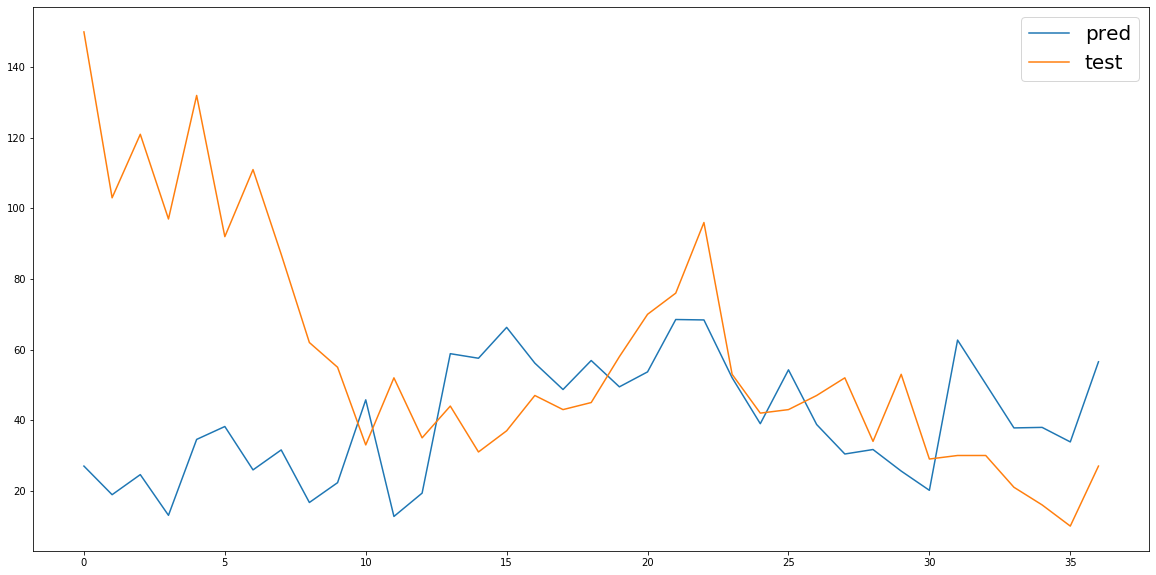

In [53]:
y_pred = model.predict(x_test)
x = range(len(y_pred))
plt.plot(x,y_pred,label = 'pred')
plt.plot(x,y_test, label = 'test')
plt.legend(fontsize=20)

In [128]:
mean_squared_error(y_pred,y_test)

949.3764036956628

In [143]:
y_pred = model.predict(x_test)

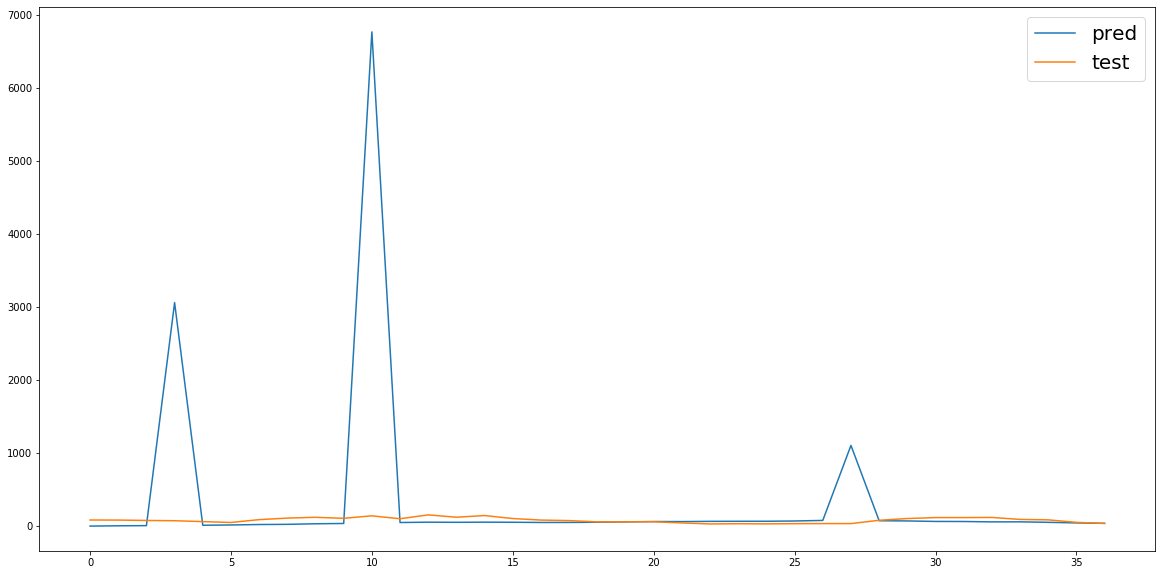

In [144]:
x = range(len(y_pred))
plt.plot(x,y_pred,label = 'pred')
plt.plot(x,y_test, label = 'test')
plt.legend(fontsize=20)

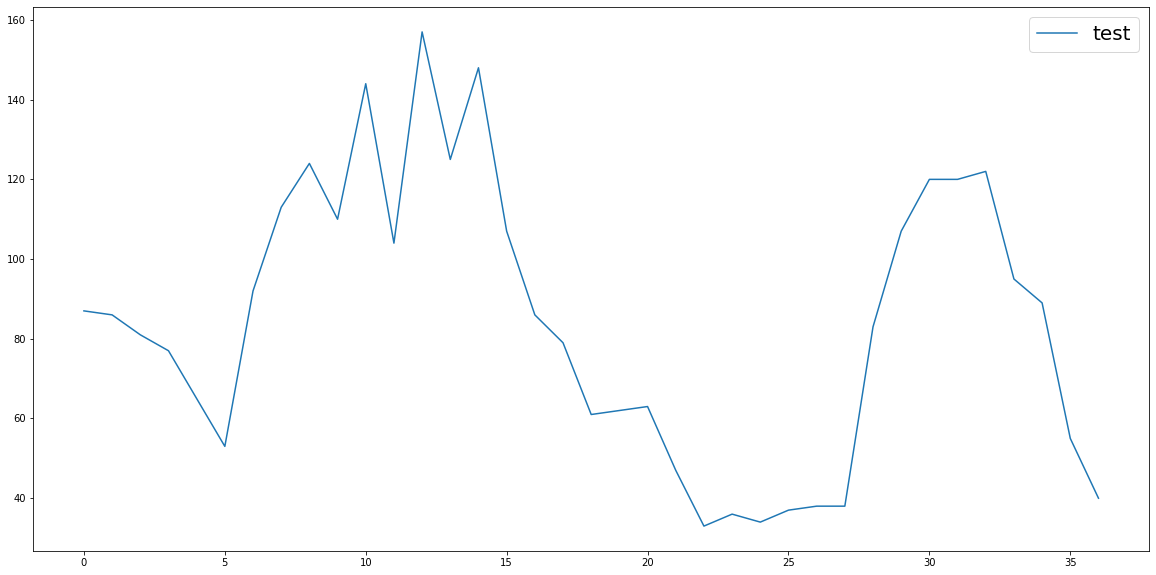

In [146]:
x = range(len(y_pred))
plt.plot(x,y_test, label = 'test')
plt.legend(fontsize=20)